<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

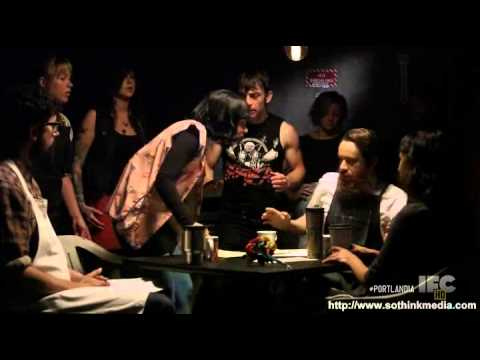

In [108]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [109]:
%pwd

'C:\\Users\\tally\\Repositories\\DS-Unit-4-Sprint-1-NLP\\module1-text-data'

In [110]:
# Start here 
from collections import Counter
import re
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

nlp = spacy.load("en_core_web_lg")

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

df = pd.read_csv(url)
df.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [112]:
###Tokenizing

#test
tokenizer = Tokenizer(nlp.vocab)
sample = "Hello, how are you today? The weather is great, python is better!"

#tokenizer function
def tokenize_review(review):
    tokenizer = Tokenizer(nlp.vocab)
    return [token.text for token in tokenizer(review)]

In [113]:
df['tokenized_review'] = df['full_review_text'].apply(tokenize_review)
df['tokenized_review'].apply(lambda x: Counter().update(x))
df['tokenized_review'].head()

0    [ , 11/25/2016, 1, check-in, Love, love, loved...
1    [ , 12/2/2016, Listed, in, Date, Night:, Austi...
2    [ , 11/30/2016, 1, check-in, Listed, in, Brunc...
3    [ , 11/25/2016, Very, cool, decor!, Good, drin...
4    [ , 12/3/2016, 1, check-in, They, are, located...
Name: tokenized_review, dtype: object

In [114]:
def count(docs):
    
    word_counts = Counter()
    appears_in = Counter()
    
    total_docs = len(docs)
    
    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))
    
    temp = zip(word_counts.keys(), word_counts.values())
    
    wc = pd.DataFrame(temp, columns=['word', 'count'])
    
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()
    
    wc['pct_total'] = wc['count'].apply(lambda x: x/total)
    
    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()
    
    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')
    
    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x/total_docs)
    
    return wc.sort_values(by='rank')

In [115]:
wc = count(df['tokenized_review'])

In [116]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
76,the,6520,27779,1.0,0.034334,0.034334,0.856092
12,and,6804,25748,2.0,0.031824,0.066157,0.893382
27,,7616,22606,3.0,0.027940,0.094097,1.000000
56,a,6181,22085,4.0,0.027296,0.121394,0.811581
3,I,5469,19780,5.0,0.024447,0.145841,0.718093


In [117]:
###Clean text function
def clean_text(tokenized_review):
    #remove dates and initial space (first two elements)
    tokenized_review = tokenized_review[2:]
    #extract word stems
    tokenized_review = [WordNetLemmatizer().lemmatize(word) for word in tokenized_review]
    #remove 100 most common words (common stop words), default stop words, blanks, and spaces
    stop_words = list(wc['word'][:100]) + list(nlp.Defaults.stop_words) + ['', ' ', 'wa']
    tokenized_review = [re.sub(r'[^a-zA-Z]', '', word) for word in tokenized_review]
    tokenized_review = [word.lower() for word in tokenized_review]
    tokenized_review = [word for word in tokenized_review if word not in stop_words]
    return tokenized_review

In [118]:
#Applying cleaning
df['tokenized_review'] = df['tokenized_review'].apply(clean_text)
df['tokenized_review'].head()

0    [checkin, loved, atmosphere, corner, style, sw...
1    [listed, date, night, austin, ambiance, austin...
2    [checkin, listed, brunch, spots, loved, eclect...
3    [cool, decor, drink, seating, overpriced, extr...
4    [checkin, located, northcross, mall, shopping,...
Name: tokenized_review, dtype: object

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [119]:
def classify_reviews(rating):
    if rating > 3:
        return 'good'
    else:
        return 'bad'

In [120]:
df['token_count'] = [len(review) for review in df['tokenized_review']]
df['star_rating'] = df['star_rating'].apply(lambda x: float(x.replace(' star rating', '')))
df['good_or_bad_review'] = df['star_rating'].apply(classify_reviews)
df.head()

,coffee_shop_name,full_review_text,star_rating,tokenized_review,token_count,good_or_bad_review
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0,"[checkin, loved, atmosphere, corner, style, sw...",39,good
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0,"[listed, date, night, austin, ambiance, austin...",20,good
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0,"[checkin, listed, brunch, spots, loved, eclect...",97,good
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0,"[cool, decor, drink, seating, overpriced, extr...",30,bad
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0,"[checkin, located, northcross, mall, shopping,...",59,good


Text(0, 0.5, 'Number of Choice Words')

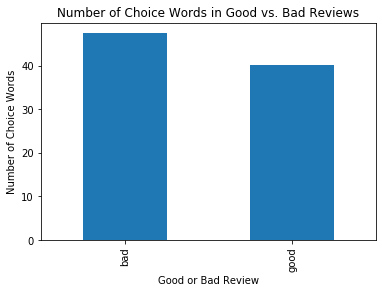

In [121]:
df.groupby('good_or_bad_review')['token_count'].mean().plot.bar()
plt.title('Number of Choice Words in Good vs. Bad Reviews')
plt.xlabel('Good or Bad Review')
plt.ylabel('Number of Choice Words')

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


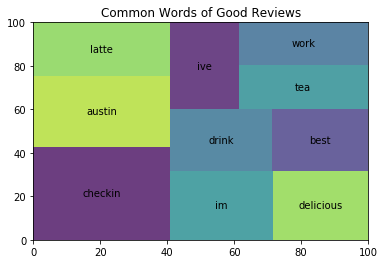

Text(0.5, 1.0, 'Common Words of Bad Reviews')

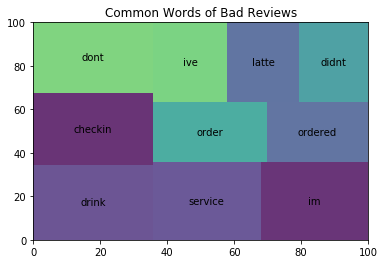

In [122]:
'''not sure why stop words werent removed'''
import squarify

wc = count(df[df['good_or_bad_review'] == 'good']['tokenized_review'])
wc_top10 = wc[wc['rank'] <= 10]

squarify.plot(sizes=wc_top10['pct_total'], label=wc_top10['word'], alpha=.8)
plt.title('Common Words of Good Reviews')
plt.show()

wc = count(df[df['good_or_bad_review'] == 'bad']['tokenized_review'])
wc_top10 = wc[wc['rank'] <= 10]

squarify.plot(sizes=wc_top10['pct_total'], label=wc_top10['word'], alpha=.8)
plt.title('Common Words of Bad Reviews')

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

